In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling',
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling',
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
0.0      1800
1.0      1296
2.0      1260
3.0      1218
4.0      1026
5.0      1008
6.0       930
7.0       912
8.0       880
9.0       798
10.0      792
11.0      759
12.0      729
13.0      720
14.0      702
15.0      693
16.0      672
17.0      640
18.0      625
19.0      570
20.0      546
21.0      506
22.0      483
23.0      448
24.0      432
25.0      384
26.0      360
27.0      360
28.0      320
29.0      312
         ... 
343.0      12
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      11
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      10
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

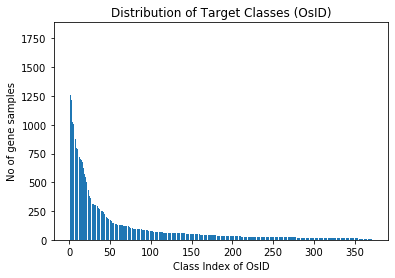

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A colu

Number of input features: 1
Fold: 1
Epoch 1/140
1846/1846 [==============================] - 4s 2ms/step - loss: 4.4077 - accuracy: 0.1060 - val_loss: 3.9691 - val_accuracy: 0.1336
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 3.6778 - accuracy: 0.1812 - val_loss: 3.6137 - val_accuracy: 0.2048
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3453 - accuracy: 0.2372 - val_loss: 3.3396 - val_accuracy: 0.2282
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0574 - accuracy: 0.2679 - val_loss: 3.1132 - val_accuracy: 0.2493
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.8510 - accuracy: 0.3119 - val_loss: 2.9489 - val_accuracy: 0.3245
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.6981 - accuracy: 0.3473 - val_loss: 2.8234 - val_accuracy: 0.3927
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5831 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.0635 - accuracy: 0.2041 - val_loss: 3.3085 - val_accuracy: 0.3366
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.6835 - accuracy: 0.4439 - val_loss: 2.5044 - val_accuracy: 0.5153
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.0257 - accuracy: 0.5607 - val_loss: 2.1098 - val_accuracy: 0.5637
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6476 - accuracy: 0.6115 - val_loss: 1.7452 - val_accuracy: 0.6365
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4128 - accuracy: 0.6451 - val_loss: 1.5832 - val_accuracy: 0.6233
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.2689 - accuracy: 0.6703 - val_loss: 1.4810 - val_accuracy: 0.6638
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.1832 - accuracy: 0.6872 - val_loss: 1.3020 - val_accuracy: 0.71

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.9735 - accuracy: 0.2275 - val_loss: 2.9877 - val_accuracy: 0.3908
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 2.2070 - accuracy: 0.5542 - val_loss: 1.9046 - val_accuracy: 0.6376
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4297 - accuracy: 0.6865 - val_loss: 1.4623 - val_accuracy: 0.7173
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.0734 - accuracy: 0.7430 - val_loss: 1.2631 - val_accuracy: 0.7538
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8918 - accuracy: 0.7806 - val_loss: 1.1356 - val_accuracy: 0.7965
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7814 - accuracy: 0.7961 - val_loss: 1.0117 - val_accuracy: 0.8013
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7062 - accuracy: 0.8109 - val_loss: 0.9423 - val_accuracy: 0.81

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 3.5340 - accuracy: 0.3324 - val_loss: 2.4749 - val_accuracy: 0.5525
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7455 - accuracy: 0.6637 - val_loss: 1.5522 - val_accuracy: 0.6992
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.0874 - accuracy: 0.7659 - val_loss: 1.0749 - val_accuracy: 0.8029
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.7660 - accuracy: 0.8237 - val_loss: 0.9035 - val_accuracy: 0.8198
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6149 - accuracy: 0.8468 - val_loss: 0.7696 - val_accuracy: 0.8506
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5366 - accuracy: 0.8590 - val_loss: 0.6989 - val_accuracy: 0.8715
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4823 - accuracy: 0.8708 - val_loss: 0.6603 - val_accuracy: 0.86

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 3.4442 - accuracy: 0.3596 - val_loss: 2.2767 - val_accuracy: 0.6103
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5599 - accuracy: 0.7094 - val_loss: 1.3576 - val_accuracy: 0.7314
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9053 - accuracy: 0.8095 - val_loss: 0.9535 - val_accuracy: 0.8128
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6327 - accuracy: 0.8558 - val_loss: 0.7682 - val_accuracy: 0.8506
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5012 - accuracy: 0.8774 - val_loss: 0.6407 - val_accuracy: 0.8713
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4242 - accuracy: 0.8926 - val_loss: 0.5750 - val_accuracy: 0.8862
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3820 - accuracy: 0.9051 - val_loss: 0.5596 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4801 - accuracy: 0.3691 - val_loss: 2.2844 - val_accuracy: 0.6004
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.6102 - accuracy: 0.6905 - val_loss: 1.3647 - val_accuracy: 0.7406
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.9346 - accuracy: 0.7987 - val_loss: 0.9949 - val_accuracy: 0.8106
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6496 - accuracy: 0.8481 - val_loss: 0.7515 - val_accuracy: 0.8354
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5144 - accuracy: 0.8705 - val_loss: 0.6585 - val_accuracy: 0.8667
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4478 - accuracy: 0.8859 - val_loss: 0.6078 - val_accuracy: 0.8821
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4014 - accuracy: 0.8950 - val_loss: 0.5315 - val_accuracy: 0.89

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4326 - accuracy: 0.3543 - val_loss: 2.2831 - val_accuracy: 0.5318
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5136 - accuracy: 0.7076 - val_loss: 1.3601 - val_accuracy: 0.7655
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.9171 - accuracy: 0.8019 - val_loss: 0.9348 - val_accuracy: 0.8312
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6607 - accuracy: 0.8444 - val_loss: 0.7617 - val_accuracy: 0.8499
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.5233 - accuracy: 0.8726 - val_loss: 0.7092 - val_accuracy: 0.8488
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4468 - accuracy: 0.8906 - val_loss: 0.6046 - val_accuracy: 0.8755
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4013 - accuracy: 0.8990 - val_loss: 0.5742 - val_accuracy: 0.86

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5892 - accuracy: 0.3386 - val_loss: 2.4496 - val_accuracy: 0.5892
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5881 - accuracy: 0.7060 - val_loss: 1.3412 - val_accuracy: 0.7516
Epoch 3/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.8937 - accuracy: 0.8183 - val_loss: 0.9593 - val_accuracy: 0.8128
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.6221 - accuracy: 0.8573 - val_loss: 0.7796 - val_accuracy: 0.8539
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4897 - accuracy: 0.8822 - val_loss: 0.6900 - val_accuracy: 0.8748
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4133 - accuracy: 0.9000 - val_loss: 0.6154 - val_accuracy: 0.8876
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3713 - accuracy: 0.9070 - val_loss: 0.6187 - val_accuracy: 0.88

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.6577 - accuracy: 0.3162 - val_loss: 2.5505 - val_accuracy: 0.5776
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.7593 - accuracy: 0.6769 - val_loss: 1.5631 - val_accuracy: 0.7408
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.0687 - accuracy: 0.7795 - val_loss: 1.1308 - val_accuracy: 0.8154
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7426 - accuracy: 0.8350 - val_loss: 0.9097 - val_accuracy: 0.8460
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5710 - accuracy: 0.8660 - val_loss: 0.7855 - val_accuracy: 0.8543
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4728 - accuracy: 0.8827 - val_loss: 0.6966 - val_accuracy: 0.8667
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4210 - accuracy: 0.8941 - val_loss: 0.6718 - val_accuracy: 0.86

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5467 - accuracy: 0.3510 - val_loss: 2.3761 - val_accuracy: 0.5890
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.5835 - accuracy: 0.7093 - val_loss: 1.3137 - val_accuracy: 0.7694
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8686 - accuracy: 0.8142 - val_loss: 0.8993 - val_accuracy: 0.8284
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5817 - accuracy: 0.8655 - val_loss: 0.6978 - val_accuracy: 0.8792
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4488 - accuracy: 0.8928 - val_loss: 0.5828 - val_accuracy: 0.9017
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3733 - accuracy: 0.9098 - val_loss: 0.5418 - val_accuracy: 0.9034
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3294 - accuracy: 0.9169 - val_loss: 0.6125 - val_accuracy: 0.89

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
1846/1846 [==============================] - 5s 2ms/step - loss: 3.4089 - accuracy: 0.3830 - val_loss: 2.1567 - val_accuracy: 0.6330
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4185 - accuracy: 0.7341 - val_loss: 1.2404 - val_accuracy: 0.7890
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8035 - accuracy: 0.8333 - val_loss: 0.8183 - val_accuracy: 0.8504
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5520 - accuracy: 0.8719 - val_loss: 0.7098 - val_accuracy: 0.8680
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4388 - accuracy: 0.8911 - val_loss: 0.5998 - val_accuracy: 0.8854
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3702 - accuracy: 0.9077 - val_loss: 0.5574 - val_accuracy: 0.8891
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3304 - accuracy: 0.9158 - val_loss: 0.4832 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4980 - accuracy: 0.3749 - val_loss: 2.2676 - val_accuracy: 0.6103
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.4955 - accuracy: 0.7278 - val_loss: 1.3056 - val_accuracy: 0.7853
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.8208 - accuracy: 0.8335 - val_loss: 0.8876 - val_accuracy: 0.8374
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5412 - accuracy: 0.8791 - val_loss: 0.6840 - val_accuracy: 0.8572
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4147 - accuracy: 0.8988 - val_loss: 0.5655 - val_accuracy: 0.8920
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3486 - accuracy: 0.9155 - val_loss: 0.5173 - val_accuracy: 0.9120
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3109 - accuracy: 0.9224 - val_loss: 0.5017 - val_accuracy: 0.90

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4355 - accuracy: 0.3809 - val_loss: 2.1356 - val_accuracy: 0.6136
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3894 - accuracy: 0.7245 - val_loss: 1.1910 - val_accuracy: 0.7747
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7813 - accuracy: 0.8264 - val_loss: 0.8768 - val_accuracy: 0.8444
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5450 - accuracy: 0.8688 - val_loss: 0.7295 - val_accuracy: 0.8631
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4249 - accuracy: 0.8963 - val_loss: 0.6510 - val_accuracy: 0.8757
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3614 - accuracy: 0.9126 - val_loss: 0.5244 - val_accuracy: 0.9131
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3203 - accuracy: 0.9197 - val_loss: 0.4814 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4178 - accuracy: 0.3750 - val_loss: 2.1486 - val_accuracy: 0.6387
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3855 - accuracy: 0.7432 - val_loss: 1.1870 - val_accuracy: 0.7820
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7615 - accuracy: 0.8364 - val_loss: 0.7926 - val_accuracy: 0.8576
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5239 - accuracy: 0.8758 - val_loss: 0.6203 - val_accuracy: 0.8766
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4184 - accuracy: 0.8954 - val_loss: 0.5353 - val_accuracy: 0.8948
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3545 - accuracy: 0.9096 - val_loss: 0.5120 - val_accuracy: 0.9001
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3133 - accuracy: 0.9219 - val_loss: 0.4495 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4370 - accuracy: 0.3666 - val_loss: 2.1433 - val_accuracy: 0.6081
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4065 - accuracy: 0.7285 - val_loss: 1.2473 - val_accuracy: 0.7648
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7990 - accuracy: 0.8260 - val_loss: 0.7951 - val_accuracy: 0.8455
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5625 - accuracy: 0.8660 - val_loss: 0.6552 - val_accuracy: 0.8669
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4429 - accuracy: 0.8893 - val_loss: 0.5641 - val_accuracy: 0.8889
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3772 - accuracy: 0.9040 - val_loss: 0.5366 - val_accuracy: 0.8902
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3371 - accuracy: 0.9137 - val_loss: 0.4470 - val_accuracy: 0.91

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.6546 - accuracy: 0.3241 - val_loss: 2.2550 - val_accuracy: 0.6196
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3870 - accuracy: 0.7364 - val_loss: 1.1220 - val_accuracy: 0.8037
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7152 - accuracy: 0.8455 - val_loss: 0.7633 - val_accuracy: 0.8629
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4787 - accuracy: 0.8903 - val_loss: 0.6036 - val_accuracy: 0.8990
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3718 - accuracy: 0.9131 - val_loss: 0.5621 - val_accuracy: 0.9030
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3084 - accuracy: 0.9254 - val_loss: 0.4723 - val_accuracy: 0.9259
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2683 - accuracy: 0.9355 - val_loss: 0.4570 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5597 - accuracy: 0.3447 - val_loss: 2.2154 - val_accuracy: 0.5941
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4467 - accuracy: 0.7275 - val_loss: 1.1974 - val_accuracy: 0.7908
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7806 - accuracy: 0.8317 - val_loss: 0.8493 - val_accuracy: 0.8678
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.5057 - accuracy: 0.8854 - val_loss: 0.6458 - val_accuracy: 0.8768
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3859 - accuracy: 0.9062 - val_loss: 0.5508 - val_accuracy: 0.9028
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3196 - accuracy: 0.9225 - val_loss: 0.4747 - val_accuracy: 0.9278
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2824 - accuracy: 0.9306 - val_loss: 0.4586 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.4055 - accuracy: 0.3517 - val_loss: 2.1057 - val_accuracy: 0.5945
Epoch 2/140
1846/1846 [==============================] - 3s 2ms/step - loss: 1.3877 - accuracy: 0.7396 - val_loss: 1.1782 - val_accuracy: 0.8163
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7548 - accuracy: 0.8524 - val_loss: 0.8045 - val_accuracy: 0.8572
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4861 - accuracy: 0.8929 - val_loss: 0.6549 - val_accuracy: 0.8909
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3584 - accuracy: 0.9150 - val_loss: 0.5349 - val_accuracy: 0.9133
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2864 - accuracy: 0.9294 - val_loss: 0.4659 - val_accuracy: 0.9217
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2422 - accuracy: 0.9418 - val_loss: 0.4261 - val_accuracy: 0.92

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.0682 - accuracy: 0.4314 - val_loss: 1.7501 - val_accuracy: 0.7036
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.1194 - accuracy: 0.7984 - val_loss: 1.0051 - val_accuracy: 0.8400
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6257 - accuracy: 0.8785 - val_loss: 0.7014 - val_accuracy: 0.8860
Epoch 4/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.4060 - accuracy: 0.9168 - val_loss: 0.5542 - val_accuracy: 0.9124
Epoch 5/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3108 - accuracy: 0.9297 - val_loss: 0.5092 - val_accuracy: 0.9133
Epoch 6/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2450 - accuracy: 0.9427 - val_loss: 0.4318 - val_accuracy: 0.9327
Epoch 7/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2159 - accuracy: 0.9470 - val_loss: 0.4198 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 3.5279 - accuracy: 0.3375 - val_loss: 2.1454 - val_accuracy: 0.6156
Epoch 2/140
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3094 - accuracy: 0.7555 - val_loss: 1.0796 - val_accuracy: 0.8275
Epoch 3/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.6798 - accuracy: 0.8612 - val_loss: 0.7277 - val_accuracy: 0.8788
Epoch 4/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4387 - accuracy: 0.8969 - val_loss: 0.5885 - val_accuracy: 0.9003
Epoch 5/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.3371 - accuracy: 0.9165 - val_loss: 0.5226 - val_accuracy: 0.9058
Epoch 6/140
1846/1846 [==============================] - 4s 2ms/step - loss: 0.2725 - accuracy: 0.9336 - val_loss: 0.5098 - val_accuracy: 0.8997
Epoch 7/140
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2450 - accuracy: 0.9371 - val_loss: 0.4125 - val_accuracy: 0.93

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

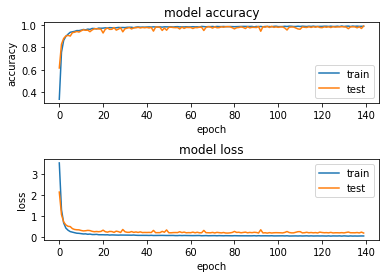

Final Test Accuracy: 0.9910812973976135


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       0.99      1.00      0.99       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         334              334        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True


In [14]:
print(models_df)

    No of input features  Model accuracy
0                      1           0.549
1                      2           0.877
2                      3           0.941
3                      4           0.970
4                      5           0.980
5                      6           0.972
6                      7           0.981
7                      8           0.974
8                      9           0.975
9                     10           0.966
10                    11           0.976
11                    12           0.976
12                    13           0.970
13                    14           0.974
14                    15           0.974
15                    16           0.981
16                    17           0.988
17                    18           0.986
18                    19           0.989
19                    20           0.991
